# IPL Match Winner Prediction - Complete ML Pipeline

In [1]:
import pandas as pd  # Data manipulation
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Statistical visualizations
from sklearn.model_selection import train_test_split  # Split data into train/test
from sklearn.preprocessing import LabelEncoder  # Encode target variable
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Tree-based models
from sklearn.linear_model import LogisticRegression  # Linear baseline model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # Evaluation metrics
import warnings  # Suppress unnecessary warnings
warnings.filterwarnings('ignore')

#### 1. LOAD DATA

In [2]:
df = pd.read_csv('IPL.csv')  # Load the IPL dataset
print("Dataset Shape:", df.shape)  # Show rows x columns
print("\nFirst 5 rows:")  # Preview data
print(df.head())


Dataset Shape: (74, 20)

First 5 rows:
   match_id           date                                         venue  \
0         1  March 26,2022                      Wankhede Stadium, Mumbai   
1         2  March 27,2022                     Brabourne Stadium, Mumbai   
2         3  March 27,2022            Dr DY Patil Sports Academy, Mumbai   
3         4  March 28,2022                      Wankhede Stadium, Mumbai   
4         5  March 29,2022  Maharashtra Cricket Association Stadium,Pune   

       team1      team2  stage toss_winner toss_decision  first_ings_score  \
0    Chennai    Kolkata  Group     Kolkata         Field               131   
1      Delhi     Mumbai  Group       Delhi         Field               177   
2   Banglore     Punjab  Group      Punjab         Field               205   
3    Gujarat    Lucknow  Group     Gujarat         Field               158   
4  Hyderabad  Rajasthan  Group   Hyderabad         Field               210   

   first_ings_wkts  second_ings_sco

In [3]:
df.columns

Index(['match_id', 'date', 'venue', 'team1', 'team2', 'stage', 'toss_winner',
       'toss_decision', 'first_ings_score', 'first_ings_wkts',
       'second_ings_score', 'second_ings_wkts', 'match_winner', 'won_by',
       'margin', 'player_of_the_match', 'top_scorer', 'highscore',
       'best_bowling', 'best_bowling_figure'],
      dtype='object')

### 2. DATA CLEANING

In [4]:
# Strip whitespace from all string columns
for col in df.select_dtypes(include=['object']).columns:  # Loop through text columns
    df[col] = df[col].str.strip()  # Remove leading/trailing spaces

In [5]:
# Convert date to datetime format
df['date'] = pd.to_datetime(
    df['date'],
    format='%B %d,%Y',
    errors='coerce'
)


In [6]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())  # Count nulls per column


Missing values:
match_id               0
date                   1
venue                  0
team1                  0
team2                  0
stage                  0
toss_winner            0
toss_decision          0
first_ings_score       0
first_ings_wkts        0
second_ings_score      0
second_ings_wkts       0
match_winner           0
won_by                 0
margin                 0
player_of_the_match    0
top_scorer             0
highscore              0
best_bowling           0
best_bowling_figure    0
dtype: int64


#### 3. REMOVE DATA LEAKAGE (POST-MATCH INFO)

In [7]:
# These columns contain info only available AFTER match ends
leakage_cols = [
    'first_ings_score',      # Score known only after match
    'first_ings_wkts',       # Wickets known only after match
    'second_ings_score',     # Score known only after match
    'second_ings_wkts',      # Wickets known only after match
    'won_by',                # Result type (runs/wickets)
    'margin',                # Win margin
    'player_of_the_match',   # Awarded after match
    'top_scorer',            # Known after match
    'highscore',             # Known after match
    'best_bowling',          # Known after match
    'best_bowling_figure',   # Known after match
    'match_id',              # Not useful for prediction
    'date'                   # Using only pre-match info
]

df_clean = df.drop(columns=leakage_cols)  # Drop all leakage columns
print(f"Columns after removing leakage: {list(df_clean.columns)}")

Columns after removing leakage: ['venue', 'team1', 'team2', 'stage', 'toss_winner', 'toss_decision', 'match_winner']


In [8]:
df_clean.head()

,venue,team1,team2,stage,toss_winner,toss_decision,match_winner
0,"Wankhede Stadium, Mumbai",Chennai,Kolkata,Group,Kolkata,Field,Kolkata
1,"Brabourne Stadium, Mumbai",Delhi,Mumbai,Group,Delhi,Field,Delhi
2,"Dr DY Patil Sports Academy, Mumbai",Banglore,Punjab,Group,Punjab,Field,Punjab
3,"Wankhede Stadium, Mumbai",Gujarat,Lucknow,Group,Gujarat,Field,Gujarat
4,"Maharashtra Cricket Association Stadium,Pune",Hyderabad,Rajasthan,Group,Hyderabad,Field,Rajasthan


#### 4. EXPLORATORY DATA ANALYSIS (EDA)

In [9]:
# Basic statistics
print("\nDataset Info:")
print(df_clean.info())  # Show column types and non-null counts


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   venue          74 non-null     object
 1   team1          74 non-null     object
 2   team2          74 non-null     object
 3   stage          74 non-null     object
 4   toss_winner    74 non-null     object
 5   toss_decision  74 non-null     object
 6   match_winner   74 non-null     object
dtypes: object(7)
memory usage: 4.2+ KB
None


In [10]:
print("\nTarget variable distribution:")
print(df_clean['match_winner'].value_counts())  # Count wins per team


Target variable distribution:
match_winner
Gujarat      12
Rajasthan    10
Banglore      9
Lucknow       9
Punjab        7
Delhi         7
Kolkata       6
Hyderabad     6
Chennai       4
Mumbai        4
Name: count, dtype: int64


<Figure size 1000x600 with 0 Axes>

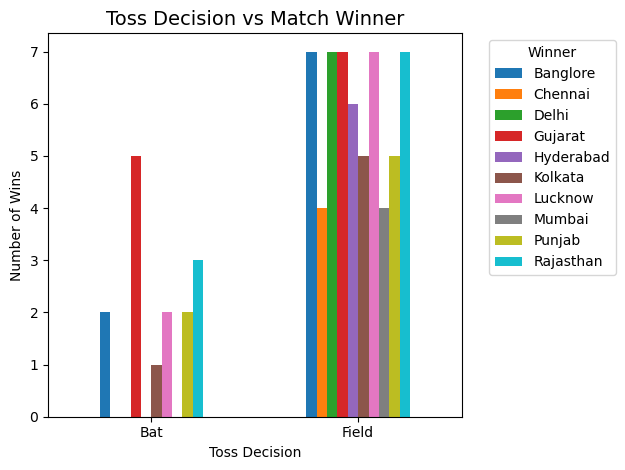

In [11]:
# Visualization 1: Toss Decision Impact
plt.figure(figsize=(10, 6))  # Create figure with size
toss_win = df.groupby(['toss_decision', 'match_winner']).size().unstack(fill_value=0)  # Group by toss decision
toss_win.plot(kind='bar', stacked=False)  # Bar plot
plt.title('Toss Decision vs Match Winner', fontsize=14)  # Add title
plt.xlabel('Toss Decision')  # X-axis label
plt.ylabel('Number of Wins')  # Y-axis label
plt.xticks(rotation=0)  # Rotate x-axis labels
plt.legend(title='Winner', bbox_to_anchor=(1.05, 1))  # Add legend outside plot
plt.tight_layout()  # Adjust spacing
plt.show()


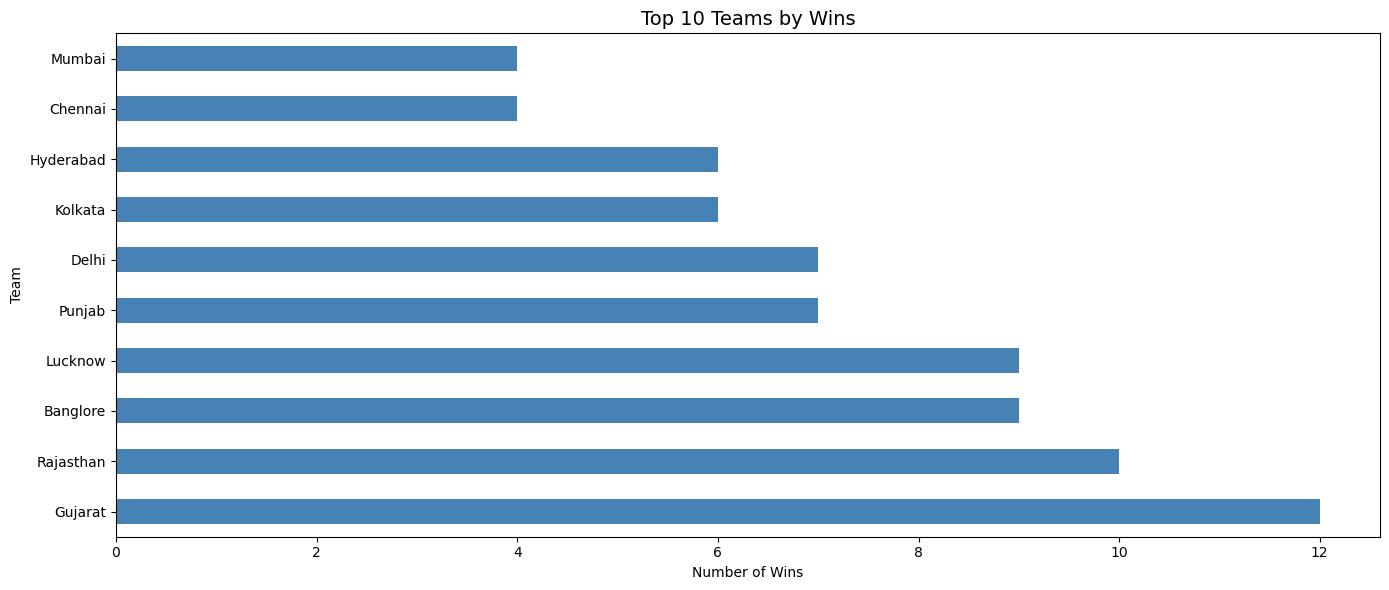

In [12]:
# Visualization 2: Venue Win Distribution
plt.figure(figsize=(14, 6))  # Create larger figure
venue_wins = df['match_winner'].value_counts().head(10)  # Top 10 winning teams
venue_wins.plot(kind='barh', color='steelblue')  # Horizontal bar plot
plt.title('Top 10 Teams by Wins', fontsize=14)  # Add title
plt.xlabel('Number of Wins')  # X-axis label
plt.ylabel('Team')  # Y-axis label
plt.tight_layout()  # Adjust spacing
plt.show()


#### 5. FEATURE ENGINEERING

In [13]:
# Create binary feature: Did team1 win the toss?
df_clean['team1_won_toss'] = (df_clean['team1'] == df_clean['toss_winner']).astype(int)  # 1 if yes, 0 if no


In [15]:
# Create binary feature: Did team2 win the toss?
df_clean['team2_won_toss'] = (df_clean['team2'] == df_clean['toss_winner']).astype(int)  # 1 if yes, 0 if no


In [16]:
print("New features created:")
print(df_clean[['team1', 'team2', 'toss_winner', 'team1_won_toss', 'team2_won_toss']].head())


New features created:
       team1      team2 toss_winner  team1_won_toss  team2_won_toss
0    Chennai    Kolkata     Kolkata               0               1
1      Delhi     Mumbai       Delhi               1               0
2   Banglore     Punjab      Punjab               0               1
3    Gujarat    Lucknow     Gujarat               1               0
4  Hyderabad  Rajasthan   Hyderabad               1               0


#### 6. ENCODING CATEGORICAL VARIABLES

In [17]:
# Separate features (X) and target (y)
X = df_clean.drop('match_winner', axis=1)  # All columns except target
y = df_clean['match_winner']  # Target variable

In [19]:
# One-Hot Encode categorical features
categorical_cols = ['team1', 'team2', 'venue', 'toss_winner', 'toss_decision', 'stage']  # Columns to encode
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)  # Create dummy variables
print(f"Shape after encoding: {X_encoded.shape}")  # Show new dimensions
print(f"Features: {X_encoded.shape[1]}")  # Total number of features


Shape after encoding: (74, 35)
Features: 35


In [20]:
# Encode target variable (team names to numbers)
le = LabelEncoder()  # Initialize label encoder
y_encoded = le.fit_transform(y)  # Convert team names to integers

print(f"\nTarget classes: {le.classes_}")  # Show team name to number mapping


Target classes: ['Banglore' 'Chennai' 'Delhi' 'Gujarat' 'Hyderabad' 'Kolkata' 'Lucknow'
 'Mumbai' 'Punjab' 'Rajasthan']


#### 7. TRAIN-TEST SPLIT

In [21]:
# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded,  # Features and target
    test_size=0.2,  # 20% for testing
    random_state=42,  # Reproducible results
    stratify=y_encoded  # Keep class distribution same in train/test
)

print(f"Training samples: {X_train.shape[0]}")  # Number of training examples
print(f"Testing samples: {X_test.shape[0]}")  # Number of testing examples


Training samples: 59
Testing samples: 15


#### 8. MODEL TRAINING

In [22]:
# Dictionary to store models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),  # Linear baseline
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5),  # Best choice
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=3)  # Advanced ensemble
}

results = {}  # Store accuracy scores

# Train and evaluate each model
for name, model in models.items():  # Loop through models
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)  # Train model on training data
    y_pred = model.predict(X_test)  # Predict on test data
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    results[name] = accuracy  # Store result
    print(f"{name} Accuracy: {accuracy:.2%}")  # Print accuracy percentage


Training Logistic Regression...
Logistic Regression Accuracy: 53.33%

Training Random Forest...
Random Forest Accuracy: 53.33%

Training Gradient Boosting...
Gradient Boosting Accuracy: 40.00%


In [ ]:


# git commit -m "feat: add comprehensive model evaluation suite
# git commit -m "feat: add feature importance visualization for Random Forest